In [6]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")




In [7]:

X_processed = preprocess.fit_transform(X)


smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_processed, y)


X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.25, random_state=42)

In [8]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, solver='lbfgs'),
    "Decision Tree": DecisionTreeClassifier(max_depth=6, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300, max_depth=12, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=350, learning_rate=0.09, max_depth=6,
        subsample=0.9, colsample_bytree=0.9, use_label_encoder=False,
        eval_metric='logloss', random_state=42
    )
}


accuracy_scores = {}

In [14]:
print("\n================ MODEL PERFORMANCE COMPARISON ================\n")

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    accuracy_scores[name] = acc

    print(f"\n----- {name} -----")
    print("Accuracy:", round(acc, 4))
    print(classification_report(y_test, preds))




================ MODEL PERFORMANCE COMPARISON ================


----- Logistic Regression -----
Accuracy: 0.7758
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       205
           1       0.77      0.74      0.76       183

    accuracy                           0.78       388
   macro avg       0.78      0.77      0.77       388
weighted avg       0.78      0.78      0.78       388


----- Decision Tree -----
Accuracy: 0.8402
              precision    recall  f1-score   support

           0       0.89      0.80      0.84       205
           1       0.80      0.89      0.84       183

    accuracy                           0.84       388
   macro avg       0.84      0.84      0.84       388
weighted avg       0.85      0.84      0.84       388


----- Random Forest -----
Accuracy: 0.8995
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       205
           1       0.85      0.95 

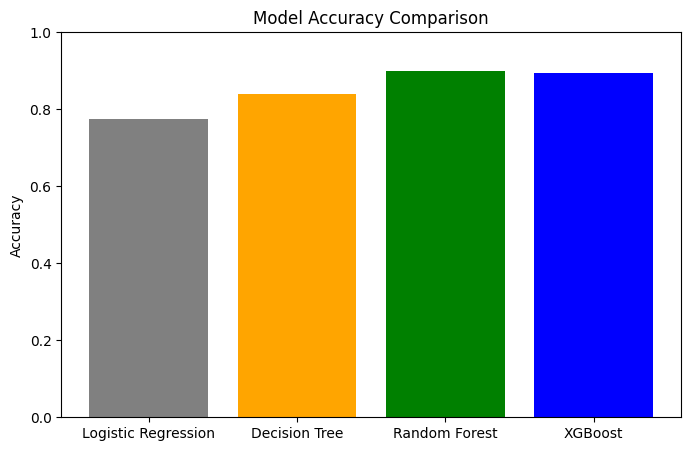

In [13]:
plt.figure(figsize=(8,5))
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color=['gray','orange','green','blue'])
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)
plt.show()


✅ Best Model Selected: Random Forest



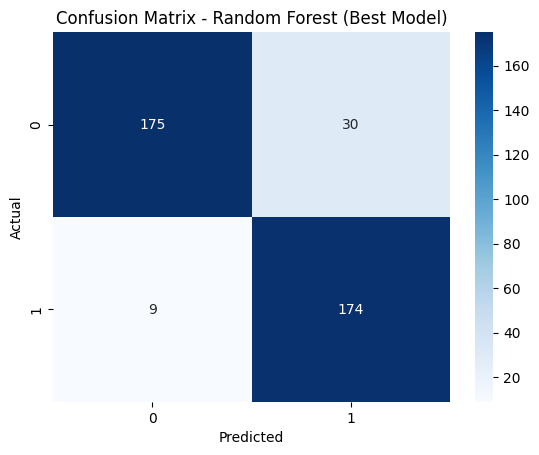

In [10]:

best_model_name = max(accuracy_scores, key=accuracy_scores.get)
best_model = models[best_model_name]

print(f"\n✅ Best Model Selected: {best_model_name}\n")

# Retrain Best Model on full training set
best_model.fit(X_train, y_train)


cm = confusion_matrix(y_test, best_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title(f"Confusion Matrix - {best_model_name} (Best Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

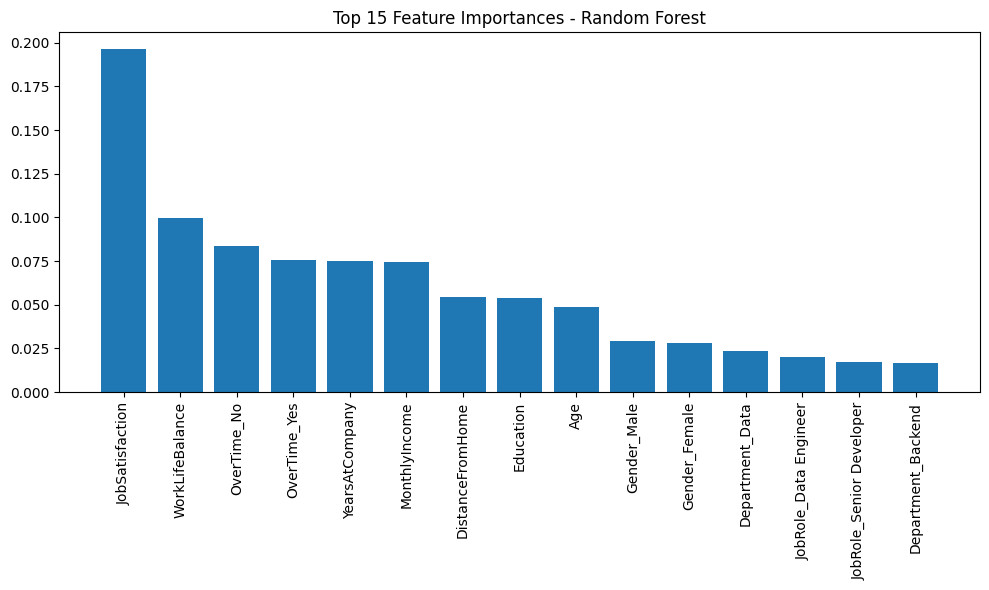

In [11]:
encoded_cols = preprocess.transformers_[0][1].get_feature_names_out(cat_cols)
num_cols = X.select_dtypes(exclude='object').columns
all_features = np.concatenate([encoded_cols, num_cols])

importances = best_model.feature_importances_ if hasattr(best_model, "feature_importances_") else None

if importances is not None:
    sorted_idx = np.argsort(importances)[::-1]
    plt.figure(figsize=(10,6))
    plt.bar(all_features[sorted_idx][:15], importances[sorted_idx][:15])
    plt.xticks(rotation=90)
    plt.title(f"Top 15 Feature Importances - {best_model_name}")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Feature importances not available for this model.")

In [12]:
def predict_employee(data_row):
    df = pd.DataFrame([data_row])
    df_enc = preprocess.transform(df)
    pred = best_model.predict(df_enc)[0]
    return "LIKELY to Leave ❌" if pred == 1 else "NOT Likely to Leave ✅"


new_emp = {
    "Age": 29,
    "Gender": "Male",
    "Department": "Backend",
    "Education": 3,
    "JobRole": "Software Engineer",
    "MonthlyIncome": 45000,
    "DistanceFromHome": 12,
    "YearsAtCompany": 1,
    "JobSatisfaction": 2,
    "WorkLifeBalance": 2,
    "OverTime": "Yes"
}

print("\nFinal Prediction for Employee →", predict_employee(new_emp))


Final Prediction for Employee → LIKELY to Leave ❌
